<a href="https://colab.research.google.com/github/phmorris610/cs39aa_project/blob/main/project_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pyLDAvis
# !pip install textstat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import sklearn
# import gensim
# import pyLDAvis
# import wordcloud
# import textblob
# import spacy
# import textstat

In [2]:
from google.colab import files
uploaded = files.upload()

data = pd.read_csv('rtom2.csv')

tomatoes = data.dropna()
tomatoes.reset_index(inplace=True)
print(tomatoes.shape)
print(tomatoes.head())




Saving rtom2.csv to rtom2.csv
(9508, 9)
   index rotten_tomatoes_link  top_critic  T_C           publisher_name  \
0      0            m/0814255       False    0           Urban Cinefile   
1      1            m/0814255       False    0      FILMINK (Australia)   
2      2            m/0814255       False    0  Sunday Mail (Australia)   
3      3            m/0814255        True    1       Hollywood Reporter   
4      4            m/0814255        True    1         Associated Press   

  review_type  Review_Type review_date  \
0       Fresh            1    2/6/2010   
1       Fresh            1    2/9/2010   
2       Fresh            1    2/9/2010   
3      Rotten            0   2/10/2010   
4      Rotten            0   2/10/2010   

                                      review_content  
0  Uma Thurman as Medusa, the gorgon with a coiff...  
1  With a top-notch cast and dazzling special eff...  
2  Whether audiences will get behind The Lightnin...  
3  What's really lacking in The Ligh

In [3]:
selections1 = ['Review_Type', 'review_content']
selections2 = ['T_C', 'review_content']
X = tomatoes[selections1].copy()
X2 = tomatoes[selections2].copy()
y = tomatoes.pop('Review_Type')
y2 = tomatoes.pop('T_C')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

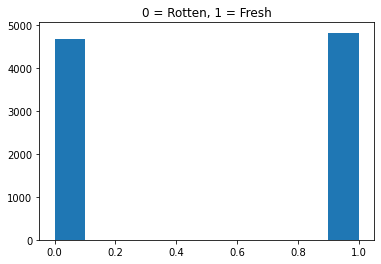

In [6]:
import matplotlib.pyplot as plt
plt.title('0 = Rotten, 1 = Fresh')
plt.hist(y)
plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

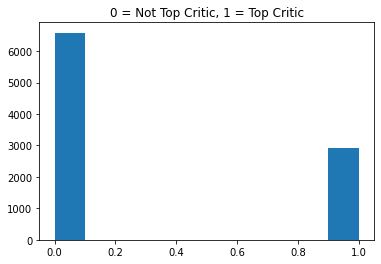

In [7]:
plt.title('0 = Not Top Critic, 1 = Top Critic')
plt.hist(y2)
plt

#Below we will tokenize and remove characters and stopwords.

In [8]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = set(stopwords.words('english'))
corpus = []
new = X['review_content'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
from collections import defaultdict

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

In [10]:
from nltk.tokenize import TreebankWordTokenizer

twt = TreebankWordTokenizer()
X['tokens_raw'] = X['review_content'].apply(lambda x: twt.tokenize(x.lower()))
chars2remove = set(
    ['.', '!', '/', '?', ',', '@', '#', '$', '%', '^', '&', '*', '_', '-', '~', 'The', 'A', '`', '+', "'", '"', '--',
     '[', ']',
     "'s", "n't"])
X['tokens_raw'] = X['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove and w not in stop])
pd.set_option("display.max_colwidth", 300)
X_tRaw = X['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove and w not in stop])
Xtclean = X_tRaw.apply(lambda x: ' '.join(x))
Xtclean.head()

0                                          uma thurman medusa gorgon coiffure writhing snakes stone-inducing hypnotic gaze one highlights bewitching fantasy
1                                                                            top-notch cast dazzling special effects tide teens next harry potter instalment
2    whether audiences get behind lightning thief hard predict. overall entertaining introduction promising new world consuming shadow potter big break free
3                                                                     really lacking lightning thief genuine sense wonder thing brings viewers back hogwarts
4                                                                                                     list ingredients movie-magic potion enjoy start finish
Name: tokens_raw, dtype: object

Let's See if Stemming makes a difference, below.

In [ ]:
from nltk.stem import PorterStemmer
py_stem = PorterStemmer()
X['tokens_raw'] = X['review_content'].apply(lambda x: py_stem.stem(x.lower()))
chars2remove = set(
    ['.', '!', '/', '?', ',', '@', '#', '$', '%', '^', '&', '*', '_', '-', '~', 'The', 'A', '`', '+', "'", '"', '--',
     '[', ']',
     "'s", "n't"])
X['tokens_raw'] = X['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove and w not in stop])
pd.set_option("display.max_colwidth", 300)
X_tRaw_stem = X['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove and w not in stop])
Xtclean_stem = X_tRaw.apply(lambda x: ' '.join(x))
Xtclean_stem.head()

0                                          uma thurman medusa gorgon coiffure writhing snakes stone-inducing hypnotic gaze one highlights bewitching fantasy
1                                                                            top-notch cast dazzling special effects tide teens next harry potter instalment
2    whether audiences get behind lightning thief hard predict. overall entertaining introduction promising new world consuming shadow potter big break free
3                                                                     really lacking lightning thief genuine sense wonder thing brings viewers back hogwarts
4                                                                                                     list ingredients movie-magic potion enjoy start finish
Name: tokens_raw, dtype: object

Now lets split the data, vectorize, then create a onehot encoding and put it through a quick and dirty model; lets use a Random Forest.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(Xtclean, y, train_size=0.80, random_state=1)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
Xtrain_hot = tfidf_vect.fit_transform(X_train).toarray()
Xval_hot = tfidf_vect.transform(X_val).toarray()
print(Xtrain_hot.shape)
print(Xval_hot.shape)

(7606, 16569)
(1902, 16569)


In [13]:
import torch
Xtrain_tense = torch.tensor(Xtrain_hot).float()
Xval_tense = torch.tensor(Xval_hot).float()
print(Xtrain_tense.shape)
print(X_train.shape)
print(Xval_tense.shape)
print(X_val.shape)

torch.Size([7606, 16569])
(7606,)
torch.Size([1902, 16569])
(1902,)


Now I will run it through the Random Forest portion of a Classification Class.

In [ ]:
class Classification:
    def __init__(self, X, y):
        self.X = X
        self.y = y


class RandomForest(Classification):
    def __init__(self, X, y):
        super().__init__(X, y)

    def rForestClass(self, Xval, yval, n):
        from sklearn.ensemble import RandomForestClassifier
        import matplotlib.pyplot as plt
        from sklearn import metrics
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
        # fig, axs = plt.subplots(nrows=1, ncols=2)
        clf = RandomForestClassifier(n_estimators=n)
        clf.fit(self.X, self.y)
        y_pred = clf.predict(self.X)
        print("RF Accuracy on Training Data: ", metrics.accuracy_score(self.y, y_pred) * 100, "%")
        display = ConfusionMatrixDisplay(confusion_matrix(self.y, y_pred), display_labels=['True', 'False'])
        display.plot()
        plt.title('Training')
        predictions = clf.predict(Xval)
        print("RF Accuracy on Validation Data: ", metrics.accuracy_score(yval, predictions) * 100, "%")
        display2 = ConfusionMatrixDisplay(confusion_matrix(yval, predictions), display_labels=['True', 'False'])
        display2.plot()
        plt.title('Validation')
        plt.show()



RF Accuracy on Training Data:  84.81462003681304 %
RF Accuracy on Validation Data:  59.67402733964248 %


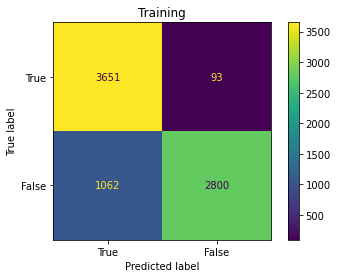

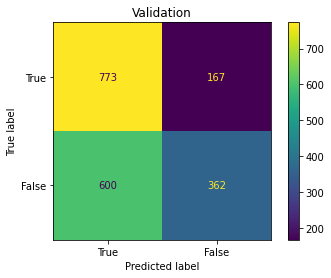

In [ ]:
rf = RandomForest(Xtrain_tense, y_train)
rf.rForestClass(Xval_tense, y_val, 2)

Wow, 84 percent accuracy, and just with 2 estimators, but this was the training data, we can see the validation data was much worse at only 61% (but still better than a coin flip).

RF Accuracy on Training Data:  99.52668945569287 %
RF Accuracy on Validation Data:  69.4006309148265 %


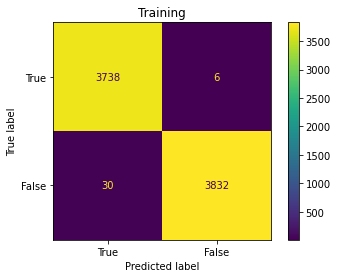

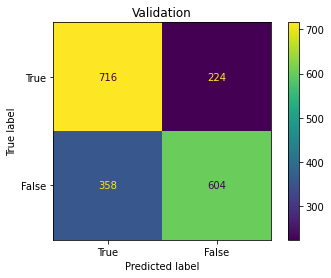

In [ ]:
rf.rForestClass(Xval_tense, y_val, 20)

Now we have 99% on the training data, but the validation is still far below at 69%. 
Note: Using steming yielded the same results.

#Now lets try a Neural Net

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, SimpleRNN
from keras.callbacks import EarlyStopping


Transform the torch tensor into a tensorflow tensor

In [15]:
import torch
import tensorflow as tf
nptrain_tensor = Xtrain_tense.numpy()
npval_tensor = Xval_tense.numpy()
Xtftrain_tensor = tf.convert_to_tensor(nptrain_tensor)
Xtfval_tensor = tf.convert_to_tensor(npval_tensor)
print(Xtftrain_tensor.shape)
print(Xtfval_tensor.shape)

(7606, 16569)
(1902, 16569)


I set up a Neural Net with two hidden layers, a dropout rate with flattening, and with relu activation and sigmoid final activation. For the optimizer is used adam for Stochastic Gradient Descent and Binary Cross Entropy as the loss function.

In [ ]:
classifier = Sequential()
classifier.add(Dense(units=10, activation='relu', input_dim=16569))
classifier.add(Dropout(0.3))
classifier.add(Flatten())
classifier.add(Dense(units=10, activation='relu'))
classifier.add(Dropout(0.2))
classifier.add(Flatten())
classifier.add(Dense(units=10, activation='relu'))
classifier.add(Dense(units=1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

I used a batch size of 200 and 15 epochs

In [ ]:
classifier.fit(Xtftrain_tensor, y_train, batch_size=200, epochs=15)
                     

Epoch 1/15
39/39 [==============================] - 2s 30ms/step - loss: 0.6931 - accuracy: 0.5076
Epoch 2/15
39/39 [==============================] - 1s 27ms/step - loss: 0.6891 - accuracy: 0.6265
Epoch 3/15
39/39 [==============================] - 1s 27ms/step - loss: 0.6635 - accuracy: 0.7330
Epoch 4/15
39/39 [==============================] - 1s 27ms/step - loss: 0.5839 - accuracy: 0.7990
Epoch 5/15
39/39 [==============================] - 1s 28ms/step - loss: 0.4544 - accuracy: 0.8717
Epoch 6/15
39/39 [==============================] - 1s 30ms/step - loss: 0.3222 - accuracy: 0.9132
Epoch 7/15
39/39 [==============================] - 1s 28ms/step - loss: 0.2248 - accuracy: 0.9365
Epoch 8/15
39/39 [==============================] - 1s 27ms/step - loss: 0.1613 - accuracy: 0.9562
Epoch 9/15
39/39 [==============================] - 1s 28ms/step - loss: 0.1157 - accuracy: 0.9717
Epoch 10/15
39/39 [==============================] - 1s 29ms/step - loss: 0.0890 - accuracy: 0.9774
Epoch 11/

In [ ]:
y_pred = classifier.predict(Xtfval_tensor)
y_pred = (y_pred > 0.5)
print(y_pred)

60/60 [==============================] - 0s 4ms/step
[[ True]
 [False]
 [ True]
 ...
 [False]
 [ True]
 [ True]]


('Accuracy Score on Validation Data:', 71.55625657202944)

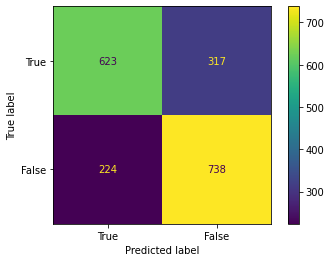

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
cm = ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred), display_labels=['True', 'False'])
cm.plot()
'Accuracy Score on Validation Data:', accuracy_score(y_val, y_pred)*100

71% on validation without bias, 70% with bias as True, 72% with dropout rate of 0.3, all with 8 epochs and batchsize of 10.
Now after changing the droupout slightly to 0.3 and 0.5 and with a batchsize of 50 and 20 epochs, I get 70% on validation.
After adding Flatten() and batchsize of 200, I get 72%
Note: Using steming yielded the same results.

In [ ]:
import torchsummary
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                165700    
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 flatten_1 (Flatten)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                1

Now lets see if Lemmatization of the reviews helps validation accuracy

In [16]:
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [17]:
X_tRawLem = X_tRaw.apply(lambda x: [lemmatizer.lemmatize(w, pos="v") for w in x])
XtLemclean = X_tRawLem.apply(lambda x: ' '.join(x))
XtLemclean.head()

0                                          uma thurman medusa gorgon coiffure writhe snake stone-inducing hypnotic gaze one highlight bewitch fantasy
1                                                                        top-notch cast dazzle special effect tide teens next harry potter instalment
2    whether audiences get behind lightning thief hard predict. overall entertain introduction promise new world consume shadow potter big break free
3                                                                  really lack lightning thief genuine sense wonder thing bring viewers back hogwarts
4                                                                                              list ingredients movie-magic potion enjoy start finish
Name: tokens_raw, dtype: object

In [18]:
from sklearn.model_selection import train_test_split
X_train_lem, X_val_lem, y_train_lem, y_val_lem = train_test_split(XtLemclean, y, train_size=0.80, random_state=10)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect_lem = TfidfVectorizer()
Xtrain_hot_lem = tfidf_vect_lem.fit_transform(X_train_lem).toarray()
Xval_hot_lem = tfidf_vect_lem.transform(X_val_lem).toarray()
print(Xtrain_hot_lem.shape)
print(Xval_hot_lem.shape)

(7606, 14162)
(1902, 14162)


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect_lem = TfidfVectorizer()
Xtrain_hot_lem = tfidf_vect_lem.fit_transform(X_train_lem).toarray()
Xval_hot_lem = tfidf_vect_lem.transform(X_val_lem).toarray()
print(Xtrain_hot_lem.shape)
print(Xval_hot_lem.shape)

torch.Size([7606, 14162])
(7606,)
torch.Size([1902, 14162])
(1902,)


RF Accuracy on Training Data:  84.32816197738627 %
RF Accuracy on Validation Data:  56.30914826498423 %


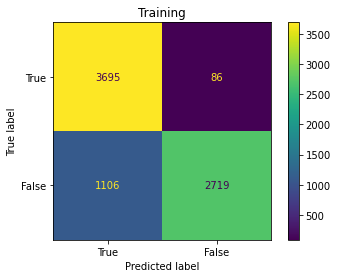

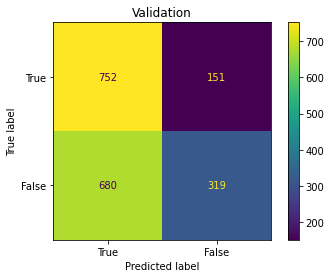

In [ ]:
rf = RandomForest(Xtrain_tense_lem, y_train_lem)
rf.rForestClass(Xval_tense_lem, y_val_lem, 2)

RF Accuracy on Training Data:  99.67131212200894 %
RF Accuracy on Validation Data:  68.5068349106204 %


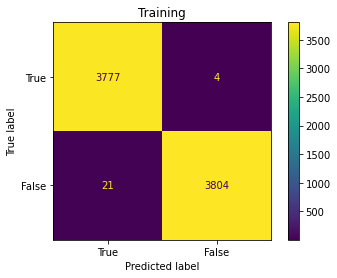

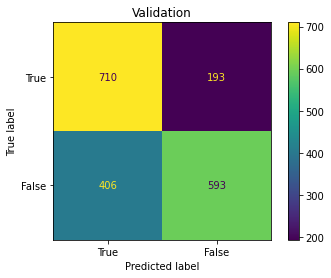

In [ ]:
rf = RandomForest(Xtrain_tense_lem, y_train_lem)
rf.rForestClass(Xval_tense_lem, y_val_lem, 20)

After using the same hyperparameters with a Random Forest the accuracy was just about the same.

In [ ]:
import torch
import tensorflow as tf
nptrain_tensor_lem = Xtrain_tense_lem.numpy()
npval_tensor_lem = Xval_tense_lem.numpy()
Xtftrain_tensor_lem = tf.convert_to_tensor(nptrain_tensor_lem)
Xtfval_tensor_lem = tf.convert_to_tensor(npval_tensor_lem)
print(Xtftrain_tensor_lem.shape)
print(Xtfval_tensor_lem.shape)

(7606, 14162)
(1902, 14162)


In [ ]:
classifier = Sequential()
classifier.add(Dense(units=20, activation='relu', input_dim=14162))
classifier.add(Dropout(0.2))
classifier.add(Flatten())
classifier.add(Dense(units=10, activation='swish'))
classifier.add(Dropout(0.3))
classifier.add(Flatten())
classifier.add(Dense(units=1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mae', 'binary_crossentropy'])
classifier.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_177 (Dense)           (None, 20)                283260    
                                                                 
 dropout_110 (Dropout)       (None, 20)                0         
                                                                 
 flatten_110 (Flatten)       (None, 20)                0         
                                                                 
 dense_178 (Dense)           (None, 10)                210       
                                                                 
 dropout_111 (Dropout)       (None, 10)                0         
                                                                 
 flatten_111 (Flatten)       (None, 10)                0         
                                                                 
 dense_179 (Dense)           (None, 1)               

In [ ]:
 fit = classifier.fit(Xtftrain_tensor_lem, y_train_lem, validation_data=(Xtfval_tensor_lem, y_val_lem), batch_size=500, epochs=100)
 fit

Epoch 1/100
16/16 [==============================] - 6s 169ms/step - loss: 0.6924 - accuracy: 0.5137 - mae: 0.4996 - binary_crossentropy: 0.6924 - val_loss: 0.6901 - val_accuracy: 0.5694 - val_mae: 0.4985 - val_binary_crossentropy: 0.6901
Epoch 2/100
16/16 [==============================] - 2s 112ms/step - loss: 0.6855 - accuracy: 0.6728 - mae: 0.4961 - binary_crossentropy: 0.6855 - val_loss: 0.6836 - val_accuracy: 0.6714 - val_mae: 0.4951 - val_binary_crossentropy: 0.6836
Epoch 3/100
16/16 [==============================] - 1s 53ms/step - loss: 0.6726 - accuracy: 0.7862 - mae: 0.4894 - binary_crossentropy: 0.6726 - val_loss: 0.6732 - val_accuracy: 0.7103 - val_mae: 0.4896 - val_binary_crossentropy: 0.6732
Epoch 4/100
16/16 [==============================] - 1s 51ms/step - loss: 0.6522 - accuracy: 0.8096 - mae: 0.4784 - binary_crossentropy: 0.6522 - val_loss: 0.6578 - val_accuracy: 0.7087 - val_mae: 0.4811 - val_binary_crossentropy: 0.6578
Epoch 5/100
16/16 [===========================

In [ ]:
y_pred_lem = classifier.predict(Xtfval_tensor_lem)
y_pred_lem = (y_pred_lem > 0.5)
print(y_pred_lem)

60/60 [==============================] - 0s 3ms/step
[[False]
 [False]
 [ True]
 ...
 [ True]
 [False]
 [False]]


('Accuracy Score on Validation Data:', 72.2397476340694)

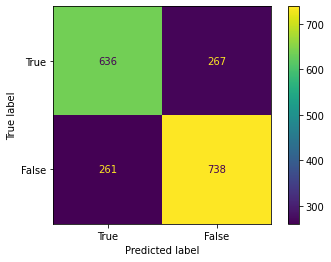

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
cm = ConfusionMatrixDisplay(confusion_matrix(y_val_lem, y_pred_lem), display_labels=['True', 'False'])
cm.plot()
'Accuracy Score on Validation Data:', accuracy_score(y_val_lem, y_pred_lem)*100

[]

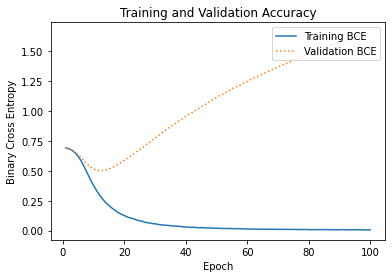

In [ ]:
err = fit.history['binary_crossentropy']
val_err = fit.history['val_binary_crossentropy']
epochs = range(1, len(err) + 1)
plt.plot(epochs, err, '-', label='Training BCE')
plt.plot(epochs, val_err, ':', label='Validation BCE')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy')
plt.legend(loc='upper right')
plt.plot()

After using a Neural Net with the same parameters, we can see a fairly sizeable increase in validation accuracy, from 71 to ~72 % accuracy by using lemmatization. We Can clearly see the model starts to overfit around 15 epochs. Lets see it with less epochs.

In [ ]:
fit = classifier.fit(Xtftrain_tensor_lem, y_train_lem, validation_data=(Xtfval_tensor_lem, y_val_lem), batch_size=500, epochs=15)
fit

Epoch 1/15
16/16 [==============================] - 6s 67ms/step - loss: 0.6922 - accuracy: 0.5655 - mae: 0.4995 - binary_crossentropy: 0.6922 - val_loss: 0.6898 - val_accuracy: 0.7103 - val_mae: 0.4983 - val_binary_crossentropy: 0.6898
Epoch 2/15
16/16 [==============================] - 1s 51ms/step - loss: 0.6840 - accuracy: 0.7528 - mae: 0.4954 - binary_crossentropy: 0.6840 - val_loss: 0.6824 - val_accuracy: 0.7476 - val_mae: 0.4945 - val_binary_crossentropy: 0.6824
Epoch 3/15
16/16 [==============================] - 1s 54ms/step - loss: 0.6693 - accuracy: 0.8052 - mae: 0.4877 - binary_crossentropy: 0.6693 - val_loss: 0.6705 - val_accuracy: 0.7660 - val_mae: 0.4882 - val_binary_crossentropy: 0.6705
Epoch 4/15
16/16 [==============================] - 1s 53ms/step - loss: 0.6457 - accuracy: 0.8397 - mae: 0.4750 - binary_crossentropy: 0.6457 - val_loss: 0.6527 - val_accuracy: 0.7629 - val_mae: 0.4784 - val_binary_crossentropy: 0.6527
Epoch 5/15
16/16 [==============================] - 

[]

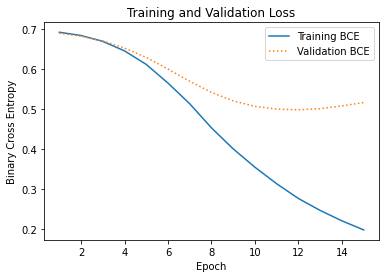

In [ ]:
err = fit.history['binary_crossentropy']
val_err = fit.history['val_binary_crossentropy']
epochs = range(1, len(err) + 1)
plt.plot(epochs, err, '-', label='Training BCE')
plt.plot(epochs, val_err, ':', label='Validation BCE')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy')
plt.legend(loc='upper right')
plt.plot()

60/60 [==============================] - 1s 5ms/step


('Accuracy Score on Validation Data:', 75.55205047318611)

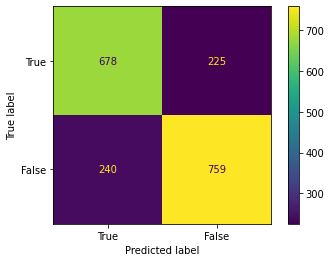

In [ ]:
y_pred_lem = classifier.predict(Xtfval_tensor_lem)
y_pred_lem = (y_pred_lem > 0.5)
cm = ConfusionMatrixDisplay(confusion_matrix(y_val_lem, y_pred_lem), display_labels=['True', 'False'])
cm.plot()
'Accuracy Score on Validation Data:', accuracy_score(y_val_lem, y_pred_lem)*100

It looks like it actually begins overfitting around 4 epochs. I'll try again. But the accuracy is much better at 75%

In [ ]:
fit = classifier.fit(Xtftrain_tensor_lem, y_train_lem, validation_data=(Xtfval_tensor_lem, y_val_lem), batch_size=500, epochs=4)
fit

Epoch 1/4
16/16 [==============================] - 2s 115ms/step - loss: 0.0725 - accuracy: 0.9866 - mae: 0.0596 - binary_crossentropy: 0.0725 - val_loss: 0.6891 - val_accuracy: 0.7424 - val_mae: 0.2851 - val_binary_crossentropy: 0.6891
Epoch 2/4
16/16 [==============================] - 1s 88ms/step - loss: 0.0696 - accuracy: 0.9869 - mae: 0.0566 - binary_crossentropy: 0.0696 - val_loss: 0.7071 - val_accuracy: 0.7434 - val_mae: 0.2842 - val_binary_crossentropy: 0.7071
Epoch 3/4
16/16 [==============================] - 1s 68ms/step - loss: 0.0655 - accuracy: 0.9883 - mae: 0.0532 - binary_crossentropy: 0.0655 - val_loss: 0.7248 - val_accuracy: 0.7413 - val_mae: 0.2840 - val_binary_crossentropy: 0.7248
Epoch 4/4
16/16 [==============================] - 1s 51ms/step - loss: 0.0585 - accuracy: 0.9908 - mae: 0.0482 - binary_crossentropy: 0.0585 - val_loss: 0.7425 - val_accuracy: 0.7397 - val_mae: 0.2836 - val_binary_crossentropy: 0.7425


60/60 [==============================] - 0s 3ms/step


('Accuracy Score on Validation Data:', 73.97476340694006)

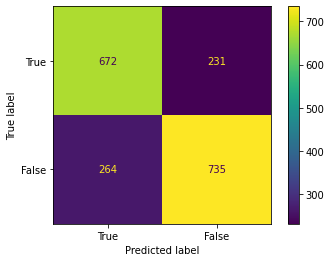

In [ ]:
y_pred_lem = classifier.predict(Xtfval_tensor_lem)
y_pred_lem = (y_pred_lem > 0.5)
cm = ConfusionMatrixDisplay(confusion_matrix(y_val_lem, y_pred_lem), display_labels=['True', 'False'])
cm.plot()
'Accuracy Score on Validation Data:', accuracy_score(y_val_lem, y_pred_lem)*100

We only have about 74% validation accuracy with 4 epochs. Lets try a Random Forest again but with more estimators just to make sure we really need a neural net.

RF Accuracy on Training Data:  99.94740993952142 %
RF Accuracy on Validation Data:  70.76761303890642 %


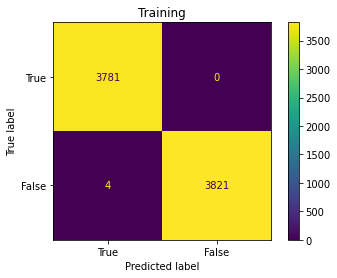

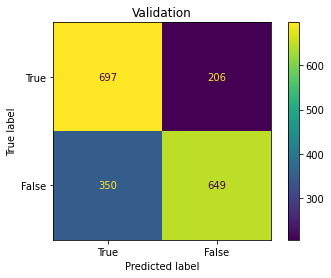

In [ ]:
rf = RandomForest(Xtrain_tense_lem, y_train_lem)
rf.rForestClass(Xval_tense_lem, y_val_lem, 100)

It looks like a Neural Net does perform better on these data, but the model is still not very accurate.

Now lets try a Recurrent Neural Network, I will use Long Short Term Memory LSTM and then Gated Recurent Unit GRU.

In [ ]:
from tensorflow.keras import layers
classifier2 = Sequential()
classifier2.add(layers.Embedding(input_dim=14162, output_dim=20))
classifier2.add(layers.LSTM(128))
classifier2.add(layers.Dense(20))
classifier2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          283240    
                                                                 
 lstm (LSTM)                 (None, 128)               76288     
                                                                 
 dense (Dense)               (None, 20)                2580      
                                                                 
Total params: 362,108
Trainable params: 362,108
Non-trainable params: 0
_________________________________________________________________


In [ ]:
classifier2.fit(Xtftrain_tensor_lem, y_train_lem, batch_size=200, epochs=5)

Epoch 1/5


The model crashed after using all available RAM... I'll have to try another computer.

Let's try using Weights and Biases

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
%%capture
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Prepare the training dataset
BATCH_SIZE = 200
# (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# x_train = np.reshape(x_train, (-1, 784))
# x_test = np.reshape(x_test, (-1, 784))

# build input pipeline using tf.data
train_dataset = tf.data.Dataset.from_tensor_slices((Xtftrain_tensor_lem, y_train_lem))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((Xtfval_tensor_lem, y_val_lem))
val_dataset = val_dataset.batch(BATCH_SIZE)

In [ ]:
def make_model():
    inputs = keras.Input(shape=(None, 200, 14162), name="digits")
    x1 = keras.layers.Dense(64, activation="relu")(inputs)
    x2 = keras.layers.Dense(64, activation="relu")(x1)
    outputs = keras.layers.Dense(10, name="predictions")(x2)

    return keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_acc_metric.update_state(y, logits)

    return loss_value

def test_step(x, y, model, loss_fn, val_acc_metric):
    val_logits = model(x, training=False)
    loss_value = loss_fn(y, val_logits)
    val_acc_metric.update_state(y, val_logits)

    return loss_value

In [ ]:
def train(train_dataset, val_dataset,  model, optimizer,
          train_acc_metric, val_acc_metric,
          epochs=20,  log_step=200, val_log_step=50):
  
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        train_loss = []   
        val_loss = []

        # Iterate over the batches of the dataset
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(x_batch_train, y_batch_train, 
                                    model, optimizer, 
                                    loss_fn, train_acc_metric)
            train_loss.append(float(loss_value))

        # Run a validation loop at the end of each epoch
        for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(x_batch_val, y_batch_val, 
                                       model, loss_fn, 
                                       val_acc_metric)
            val_loss.append(float(val_loss_value))
            
        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        val_acc = val_acc_metric.result()
        print("Validation acc: %.4f" % (float(val_acc),))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        # ⭐: log metrics using wandb.log
        wandb.log({'epochs': epoch,
                   'loss': np.mean(train_loss),
                   'acc': float(train_acc), 
                   'val_loss': np.mean(val_loss),
                   'val_acc':float(val_acc)})

In [ ]:
# initialize wandb with your project name and optionally with configutations.
# play around with the config values and see the result on your wandb dashboard.
config = {
              "learning_rate": 0.001,
              "epochs": 100,
              "batch_size": 200,
              "log_step": 200,
              "val_log_step": 50
              
           } #"architecture": "CNN", "dataset": "CIFAR-10"
              

run = wandb.init(project='my-tf-integration', config=config)
config = wandb.config

# Initialize model.
model = make_model()

# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.SGD(learning_rate=config.learning_rate)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

train(train_dataset,
      val_dataset, 
      model,
      optimizer,
      train_acc_metric,
      val_acc_metric,
      epochs=config.epochs, 
      log_step=config.log_step, 
      val_log_step=config.val_log_step)

run.finish()  # In Jupyter/Colab, let us know you're finished!


Start of epoch 0
Training acc over epoch: 0.4377
Validation acc: 0.4769

Start of epoch 1
Training acc over epoch: 0.5160
Validation acc: 0.4784

Start of epoch 2
Training acc over epoch: 0.5095
Validation acc: 0.4805

Start of epoch 3
Training acc over epoch: 0.5029
Validation acc: 0.4753

Start of epoch 4
Training acc over epoch: 0.4976
Validation acc: 0.4758

Start of epoch 5
Training acc over epoch: 0.4982
Validation acc: 0.4742

Start of epoch 6
Training acc over epoch: 0.4972
Validation acc: 0.4748

Start of epoch 7
Training acc over epoch: 0.4972
Validation acc: 0.4748

Start of epoch 8
Training acc over epoch: 0.4971
Validation acc: 0.4748

Start of epoch 9
Training acc over epoch: 0.4971
Validation acc: 0.4748

Start of epoch 10
Training acc over epoch: 0.4971
Validation acc: 0.4748

Start of epoch 11
Training acc over epoch: 0.4971
Validation acc: 0.4748

Start of epoch 12
Training acc over epoch: 0.4971
Validation acc: 0.4748

Start of epoch 13
Training acc over epoch: 0.49

acc,▁▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▇▆▇▇▇███▇█▇▇██▇
epochs,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▃▄█▆▆▇▇██▇█
val_loss,██▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.51551
epochs,99
loss,0.73375
val_acc,0.52576
val_loss,0.73338


Using Weights and Biases I get different results (https://wandb.ai/phmorris610/my-tf-integration/runs/1umrxxwi), I don't think I used it correctly...

Just for fun lets see how the model does on Top Critic or Not Top Critic

In [21]:
from sklearn.model_selection import train_test_split
X_train_lem, X_val_lem, y_train_lem, y_val_lem = train_test_split(XtLemclean, y2, train_size=0.80, random_state=10)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect_lem = TfidfVectorizer()
Xtrain_hot_lem = tfidf_vect_lem.fit_transform(X_train_lem).toarray()
Xval_hot_lem = tfidf_vect_lem.transform(X_val_lem).toarray()
print(Xtrain_hot_lem.shape)
print(Xval_hot_lem.shape)

(7606, 14162)
(1902, 14162)


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect_lem = TfidfVectorizer()
Xtrain_hot_lem = tfidf_vect_lem.fit_transform(X_train_lem).toarray()
Xval_hot_lem = tfidf_vect_lem.transform(X_val_lem).toarray()
print(Xtrain_hot_lem.shape)
print(Xval_hot_lem.shape)

(7606, 14162)
(1902, 14162)


In [26]:
classifier = Sequential()
classifier.add(Dense(units=20, activation='relu', input_dim=14162))
classifier.add(Dropout(0.2))
classifier.add(Flatten())
classifier.add(Dense(units=10, activation='swish'))
classifier.add(Dropout(0.3))
classifier.add(Flatten())
classifier.add(Dense(units=1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mae', 'binary_crossentropy'])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                283260    
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 flatten_2 (Flatten)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 flatten_3 (Flatten)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [27]:
import torch
import tensorflow as tf
nptrain_tensor_lem = Xtrain_tense_lem.numpy()
npval_tensor_lem = Xval_tense_lem.numpy()
Xtftrain_tensor_lem = tf.convert_to_tensor(nptrain_tensor_lem)
Xtfval_tensor_lem = tf.convert_to_tensor(npval_tensor_lem)
print(Xtftrain_tensor_lem.shape)
print(Xtfval_tensor_lem.shape)

(7606, 14162)
(1902, 14162)


In [32]:
fit = classifier.fit(Xtftrain_tensor_lem, y_train_lem, validation_data=(Xtfval_tensor_lem, y_val_lem), batch_size=500, epochs=30)
fit

Epoch 1/30
16/16 [==============================] - 2s 112ms/step - loss: 0.2661 - accuracy: 0.9214 - mae: 0.2064 - binary_crossentropy: 0.2661 - val_loss: 0.7205 - val_accuracy: 0.6441 - val_mae: 0.3917 - val_binary_crossentropy: 0.7205
Epoch 2/30
16/16 [==============================] - 1s 57ms/step - loss: 0.2386 - accuracy: 0.9377 - mae: 0.1862 - binary_crossentropy: 0.2386 - val_loss: 0.7517 - val_accuracy: 0.6425 - val_mae: 0.3899 - val_binary_crossentropy: 0.7517
Epoch 3/30
16/16 [==============================] - 1s 55ms/step - loss: 0.2166 - accuracy: 0.9411 - mae: 0.1693 - binary_crossentropy: 0.2166 - val_loss: 0.7817 - val_accuracy: 0.6383 - val_mae: 0.3909 - val_binary_crossentropy: 0.7817
Epoch 4/30
16/16 [==============================] - 1s 59ms/step - loss: 0.1963 - accuracy: 0.9468 - mae: 0.1536 - binary_crossentropy: 0.1963 - val_loss: 0.8237 - val_accuracy: 0.6393 - val_mae: 0.3853 - val_binary_crossentropy: 0.8237
Epoch 5/30
16/16 [==============================] -

In [33]:
y_pred_lem = classifier.predict(Xtfval_tensor_lem)
y_pred_lem = (y_pred_lem > 0.5)
print(y_pred_lem)

60/60 [==============================] - 0s 3ms/step
[[False]
 [False]
 [ True]
 ...
 [False]
 [False]
 [False]]


('Accuracy Score on Validation Data:', 62.407991587802314)

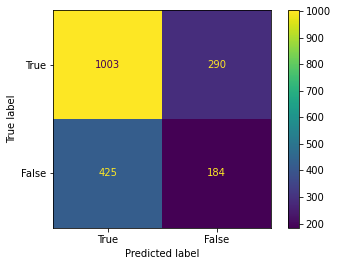

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
cm = ConfusionMatrixDisplay(confusion_matrix(y_val_lem, y_pred_lem), display_labels=['True', 'False'])
cm.plot()
'Accuracy Score on Validation Data:', accuracy_score(y_val_lem, y_pred_lem)*100

The Model did very poorly on this preditor variable, there were far more Not Top Critic's than the latter, and we do see more false positives, I assume we just don't have a good enough sample of Top Critics to predict.